In [ ]:
# Hide raw notebook code in exported HTML
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show) {
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form><input type="button" value="Return home" onclick="location.href='https://mlnoga.github.io/covid19-analysis/'"></input>
<input type="button" value="Show/hide code" onclick="code_toggle()"></input></form>

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-161715363-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-161715363-1');
</script>
''')

# Covid-19 Data Analysis March 28th

As of March 27th end of day, there were 593k confirmed cases of Covid-19 globally per the [Johns Hopkins data](https://github.com/CSSEGISandData/COVID-19). This figure continues to grow at 12% per day, and has fluctuated in the 10-12% range in the past few days. 27k people have died from Covid-19 globally. These fatal outcomes are growing at 13.5% per day, also fluctuating around the 12-14% mark. Fatal outcomes correspond to 4.6% of confirmed cases.

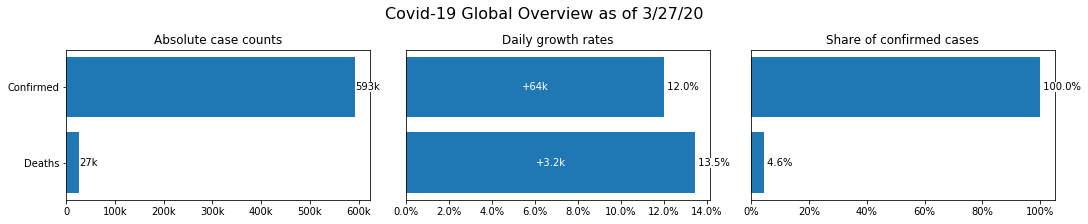

In [2]:
# Import required libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy  as np
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from scipy.special import expit

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

import datetime as datetime
import operator
import sys
import warnings
import math

# Load data and group by country/region
def loadAndGroup(fileName, groupBy="Country/Region"):
    df=pd.read_csv(fileName)
    df=df.groupby(groupBy).sum()
    return df
    
# Load data
confd =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#recovd=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
deaths=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
population=loadAndGroup('./population.csv','Country')
today =confd.columns[-1]

# Calculate new, previous and total as well as growth rate from time series
def newPrevTotalGrowth(df):
    df1        =df.loc[:, df.columns[-2]:]
    prev, total=df1.sum(axis=0)
    delta      =total-prev
    return delta, prev, total, delta/prev if prev!=0 else 0

# Calculate overall data sets for overview plots
confdNew,  confdPrev,  confdTotal,  confdGrowth =newPrevTotalGrowth(confd)
#recovdNew, recovdPrev, recovdTotal, recovdGrowth=newPrevTotalGrowth(recovd)
deathsNew, deathsPrev, deathsTotal, deathsGrowth=newPrevTotalGrowth(deaths)

#closedNew, closedPrev, closedTotal=recovdNew+deathsNew, recovdPrev+deathsPrev, recovdTotal+deathsTotal
#closedGrowth=closedNew/closedPrev if closedPrev!=0 else 0
#activeNew, activePrev, activeTotal=confdNew-closedNew, confdPrev-closedPrev, confdTotal-closedTotal
#activeGrowth=activeNew/activePrev if activePrev!=0 else 0

labels=['Confirmed', 'Deaths']
valuesTotal=[confdTotal, deathsTotal]
valuesNew=[confdNew, deathsNew]
valuesPrev=[confdPrev, deathsPrev]
valuesPerc=[1, deathsTotal/confdTotal]
valuesGrowth=[confdGrowth, deathsGrowth]

#labels=['Confirmed', 'Active', 'Closed', 'Recovered', 'Deaths']
#valuesTotal=[confdTotal, activeTotal, closedTotal, recovdTotal, deathsTotal]
#valuesNew=[confdNew, activeNew, closedNew, recovdNew, deathsNew]
#valuesPrev=[confdPrev, activePrev, closedPrev, recovdPrev, deathsPrev]
#valuesPerc=[1, activeTotal/confdTotal, closedTotal/confdTotal, recovdTotal/confdTotal, deathsTotal/confdTotal]
#valuesGrowth=[confdGrowth, activeGrowth, closedGrowth, recovdGrowth, deathsGrowth]

# Prepare overview plot
plt.rcParams['figure.figsize'] = [15, 3]
fig, ax=plt.subplots(nrows=1, ncols=3, constrained_layout=True)
fig.suptitle('Covid-19 Global Overview as of %s' % today, fontsize="16")

# Human readable formatting for figures ranging in single digits, thousands, millions and billions
def humanReadable(x):
    if math.isnan(x):
        return "NaN"
    if x<0:
        return "-"+humanReadable(-x)
    if x==0:
        return "0"
    formats=[ (10000000000, 1000000000,"%.0fb"), (1000000000,1000000000, "%.1fb"), (10000000, 1000000, "%.0fm"), 
             (1000000, 1000000, "%.1fm"), (10000,1000,"%.0fk"), (1000,1000,"%.1fk"), (10,1, "%d"), (0,1, "%.1f") ]
    for threshold, divider, formatString in formats:
        if x>=threshold:
            return formatString % (x/divider)

@plticker.FuncFormatter
def hrFormatter(x, pos):
    return humanReadable(x)

# Left side: case counts
ax[0].set_title('Absolute case counts')
#ax[0].get_yaxis().set_visible(False)
#ax2 = ax[0].twinx()
ax[0].invert_yaxis()
#ax2.invert_xaxis()
ax[0].xaxis.set_major_formatter(hrFormatter)
ax[0].barh(labels, valuesTotal)
for i, v in enumerate(valuesTotal):
    ax[0].text(v, i, humanReadable(v), ha='left', va='center', color='k', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')

# Middle: Growth rates
ax[1].set_title('Daily growth rates')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].barh(labels, valuesGrowth)
for i, v in enumerate(zip(valuesGrowth, valuesNew)):
    ax[1].text(v[0]/2, i, "+"+humanReadable(v[1]), ha='center', va='center', color='w')
for i, v in enumerate(valuesGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')
    
# Right: Percentages
ax[2].set_title('Share of confirmed cases')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[2].barh(labels, valuesPerc)
for i, v in enumerate(valuesPerc):
    ax[2].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')
        


## Global Time Series

Exponential growth appears to continue unabated. The first exponential growth wave in China plateaued in mid-February. Since then, the global spread of the disease has launched a second exponential growth wave of significantly higher magnitude. 

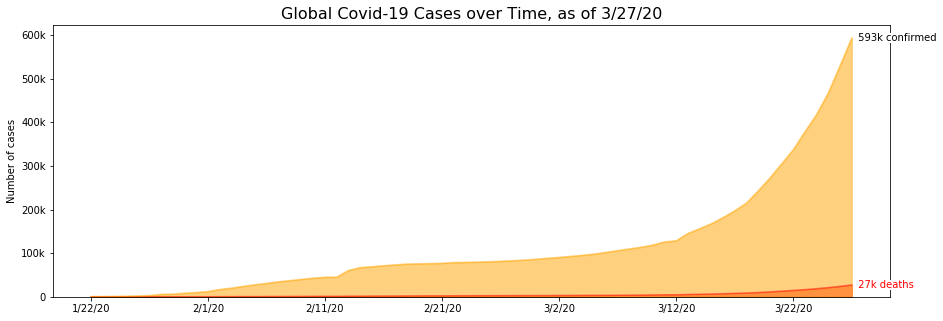

In [3]:
# Aggregate time series data on global level
globalConfd=confd.loc[:, confd.columns[2]:].sum(axis=0)
#globalRecovd=recovd.loc[:, confd.columns[2]:].sum(axis=0)
globalDeaths=deaths.loc[:, confd.columns[2]:].sum(axis=0)
#globalClosed=globalRecovd+globalDeaths
#globalActive=globalConfd-globalClosed
globalDF=pd.DataFrame({
    'Deaths':globalDeaths, 
#    'Active':globalActive,
#    'Recovered':globalRecovd,
    'Confirmed':globalConfd
})

# Prepare stacked area plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
#colors=['r', 'orange', 'g']
colors=['r', 'orange']
globalDF.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Global Covid-19 Cases over Time, as of %s" % today, fontsize=16)
ax.set_ylabel("Number of cases")
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
#c, r, d, a, cl=globalConfd[x], globalRecovd[x], globalDeaths[x], globalActive[x], globalClosed[x]
c, d=globalConfd[x], globalDeaths[x]
ax.text(xPos+0.25, d, " %s deaths" %  humanReadable(d), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#ax.text(xPos, d+a/2, " %s active" %  humanReadable(a), ha='left', va='center', c='orange')
#ax.text(xPos, d+a+r/2, " %s recovered" %  humanReadable(r), ha='left', va='center', c='g')
ax.text(xPos+00.25, c, " %s confirmed" % humanReadable(c), ha='left', va='center', c='k', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()


Absolute daily case growth continues to expand, although daily fluctuations in rate are apparent. 

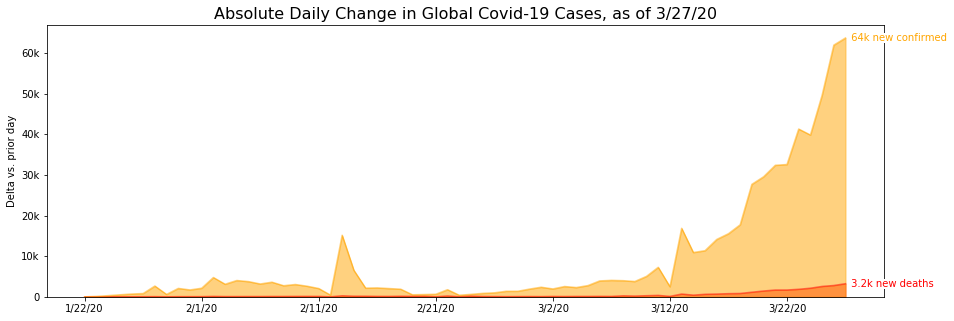

In [4]:
# Calculate daily deltas
globalConfdDelta=globalConfd.diff()
#globalRecovdDelta=-globalRecovd.diff()
globalDeathsDelta=globalDeaths.diff()
globalDFDelta=pd.DataFrame({
    'DeathsDelta':globalDeathsDelta, 
#    'RecoveredDelta':globalRecovdDelta,
    'ConfirmedDelta':globalConfdDelta
})

# Prepare area plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
#colors=['r', 'g', 'orange' ]
colors=['r', 'orange' ]
globalDFDelta.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Absolute Daily Change in Global Covid-19 Cases, as of %s" % today, fontsize=16)
ax.set_ylabel("Delta vs. prior day")
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
#c, r, d=globalConfdDelta[x], globalRecovdDelta[x], globalDeathsDelta[x]
c, d=globalConfdDelta[x], globalDeathsDelta[x]
ax.text(xPos+0.25, d, " %s new deaths" % humanReadable(d), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#ax.text(xPos, r+d, " %s new recovered" % humanReadable(r), ha='left', va='center', c='g')
ax.text(xPos+0.25, c, " %s new confirmed" % humanReadable(c), ha='left', va='center', c='orange', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

Percentage growth figures remain in the 11-12% range for new confirmed cases, and in the 12-14% range for new fatal outcomes globally.

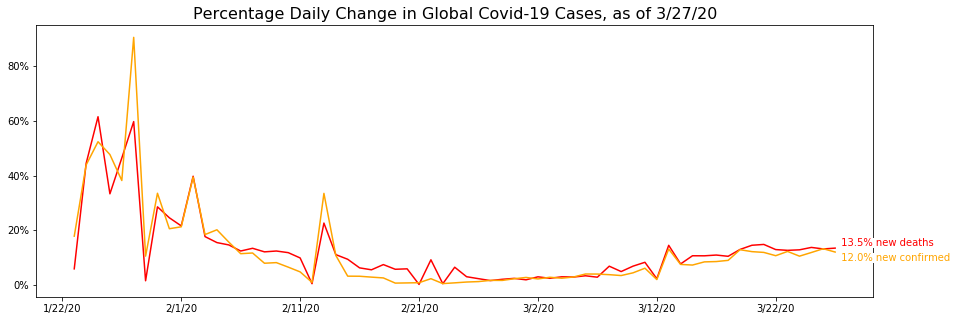

In [5]:
# Calculate daily deltas
globalConfdDeltaPerc=globalConfdDelta/globalConfd.shift(periods=1)
#globalRecovdDeltaPerc=-globalRecovdDelta/globalRecovd.shift(periods=1)
globalDeathsDeltaPerc=globalDeathsDelta/globalDeaths.shift(periods=1)
globalDFDeltaPerc=pd.DataFrame({
    'DeathsDeltaPerc':globalDeathsDeltaPerc, 
#    'RecoveredDeltaPerc':globalRecovdDeltaPerc,
    'ConfirmedDeltaPerc':globalConfdDeltaPerc
})

# Prepare line plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
#colors=['r', 'g', 'orange' ]
colors=['r', 'orange' ]
globalDFDeltaPerc.plot(ax=ax, kind='line', stacked=False, color=colors)
ax.set_title("Percentage Daily Change in Global Covid-19 Cases, as of %s" % today, fontsize=16)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
#c, r, d=globalConfdDeltaPerc[x], globalRecovdDeltaPerc[x], globalDeathsDeltaPerc[x]
c, d=globalConfdDeltaPerc[x], globalDeathsDeltaPerc[x]
ax.text(xPos+0.25, d+0.02, " %.1f%% new deaths" % (d*100), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#ax.text(xPos, r, " %.1f%% new recovered" % (r*100), ha='left', va='center', c='g')
ax.text(xPos+0.25, c-0.02, " %.1f%% new confirmed" % (c*100), ha='left', va='center', c='orange', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

Crude case fatality rate (CFR), measured as the number of fatal outcomes divided by the number of confirmed cases, continues to drift upwards.

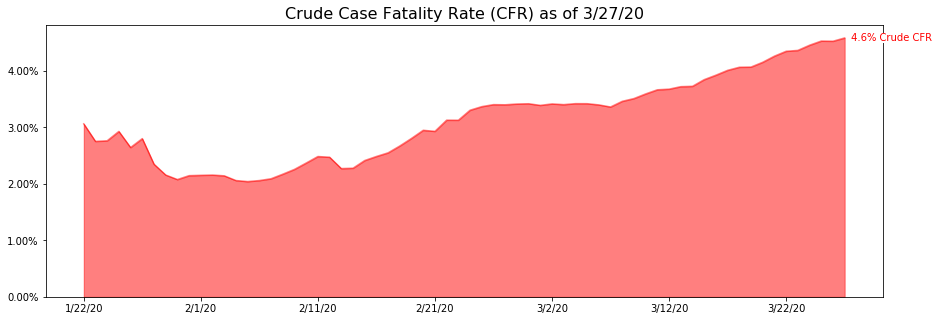

In [6]:
# Calculate daily deltas
globalCrudeCFR=globalDeaths/globalConfd
globalDFCrudeCFR=pd.DataFrame({'Crude CFR':globalCrudeCFR})

# Prepare line plot
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
colors=['r']
globalCrudeCFR.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Crude Case Fatality Rate (CFR) as of %s" % today, fontsize=16)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))

# Plot and label the values
xPos=len(globalConfd.index)-1
cfr=globalCrudeCFR[x]
ax.text(xPos+0.25, cfr, " %.1f%% Crude CFR" % (cfr*100), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

## Country Overview

The US now register more confirmed cases than China and Italy, and has crossed the 100k cases mark. The number of cases in Italy, Spain, Germany and France exceeds Iran. 

In terms of growth rates, the UK, the US and Portugal  register in the mid-20s. The growth rate in Germany is back up around 16%, simliar to Spain, France, the Netherlands and Belgium. 

Cases per capita are a proxy for infection risk from social interaction. Among major western countries, Spain, Italy and Switzerland stand out with 140-150 cases per 100k population, up 5-15 from yesterday.

Italy with 9k and Spain with 5k have more fatal outcomes each than China with 3.3k, where the first wave raged.

Crude case fatality rates (CFR), measured as number of fatal outcomes per number of confirmed cases, continue to climb in Italy with 10.6%, as well as Spain and Iran, with 7-8%, possibly due to overwhelmed health systems. China, France, the UK, an the Netherlands are in the 4-6% range. The comparatively low CFR in Germany keeps creeping up 0.1 ppt to 0.7%. Hypotheses include early and vigorous testing, as well as high ratios of nurses and ICU beds per capita; however, Germany is also still early in the epidemic. The US stands at 1.6pt, up 0.2 ppt from yesterday.

Alternative measures of case fatality rate, e.g. based on the number of total cases with known outcomes, currently cannot be calculated from the Johns Hopkins dataset because it no longer tracks recoveries.

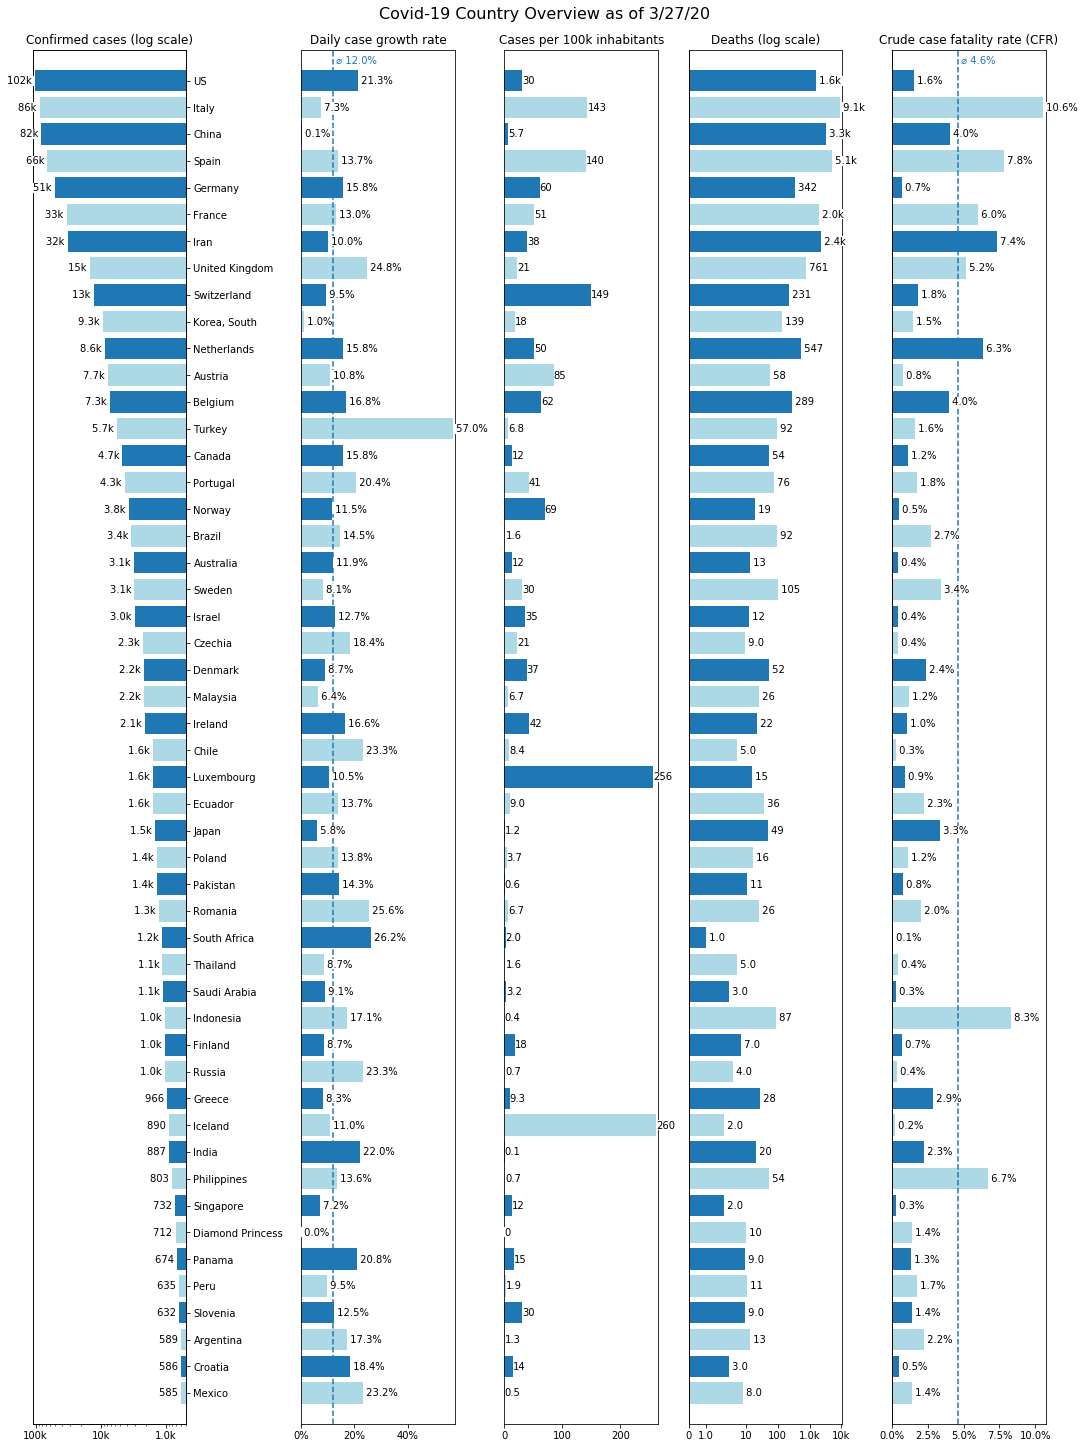

In [7]:
def lastGrowth(data):
    if len(data)>=2 and data[-2]>0:
        return data[-1]/data[-2]-1
    return 0    

# Calculate summary stats for all countries with number of cases above the threshold
threshold=100
validCountries=[]
for name in confd.index.values:
    conf1=confd.loc[name, confd.columns[2]:] # select row for given country, filter out lat/lon columns
    confv=conf1.to_numpy()
    if confv[-1]>=threshold:
        #recovd1=recovd.loc[name, confd.columns[2]:]
        #recovdv=recovd1.to_numpy()

        death1=deaths.loc[name, confd.columns[2]:]
        deathv=death1.to_numpy()

        summary={
            'Name':name,
            'Cases':confv[-1],
            'CaseGrowth':lastGrowth(confv),
            #'Recovered':recovdv[-1],
            #'RecoveredGrowth':lastGrowth(recovdv),
            'Deaths':deathv[-1],
            'DeathsGrowth':lastGrowth(deathv),
            'CFRTotal':deathv[-1]/confv[-1],
            #'CFROutcome':deathv[-1]/(deathv[-1] + recovdv[-1]) if deathv[-1]+recovdv[-1]>0 else 0,
        }
        validCountries.append(summary)

# Prepare sorted stats, and limit to top countries
validCountries.sort(key=lambda x: x['Cases'], reverse=True)
validCountries=validCountries[:50]

# Prepare data for plots
countryNames=[x['Name'] for x in validCountries]
countryCases=[x['Cases'] for x in validCountries]
countryGrowth=[x['CaseGrowth'] for x in validCountries]
countryDeaths=[x['Deaths'] for x in validCountries]
countryCFRTotal=[x['CFRTotal'] for x in validCountries]
countryPop1000=[population.loc[x]['PopulationInThousands'] for x in countryNames]
countryCasesPerPop1000=[cases/pop if pop!=0 else 0 for cases, pop in zip(countryCases, countryPop1000)]

# Prepare overview plot
plt.rcParams['figure.figsize'] = [15, 20]
fig, ax=plt.subplots(nrows=1, ncols=5, constrained_layout=True)
fig.suptitle('Covid-19 Country Overview as of %s' % today, fontsize="16")
alternatingColors=['tab:blue','lightblue']*int(len(countryNames)/2)

# Left hand side: Plot lastest confirmed cases by country
ax[0].set_xscale('log')
ax[0].set_title('Confirmed cases (log scale)')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames, countryCases, color=alternatingColors)
for i, v in enumerate(countryCases):
    ax2.text(v, i, "%s " % humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle left: Plot latest growth rate by country
ax[1].set_title('Daily case growth rate')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].margins(0.015)
ax[1].barh(countryNames, countryGrowth, color=alternatingColors)
for i, v in enumerate(countryGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle: Plot cases per 1000 population
ax[2].set_title('Cases per 100k inhabitants')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(hrFormatter)
ax[2].margins(0.015)
countryCasesPerPop100k=np.array(countryCasesPerPop1000)*100
ax[2].barh(countryNames, countryCasesPerPop100k, color=alternatingColors)
for i, v in enumerate(countryCasesPerPop100k):
    ax[2].text(v, i, hrFormatter(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[1].axvline(x=confdGrowth, ymin=0, ymax=len(countryNames), ls="--")
ax[1].text(confdGrowth, -0.75, " \u2300 %.1f%%" % (confdGrowth*100), ha='left', va='center', color=line.get_color())

# Middle right: Plot deaths by country
ax[3].set_title('Deaths (log scale)')
ax[3].invert_yaxis()
ax[3].get_yaxis().set_visible(False)
ax[3].set_xscale('symlog')
ax[3].xaxis.set_major_formatter(hrFormatter)
ax[3].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[3].margins(0.015)
ax[3].barh(countryNames, countryDeaths, color=alternatingColors)
for i, v in enumerate(countryDeaths):
    if v!=0:
        ax[3].text(v, i, " %s " % humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Right: Plot CFR by country
ax[4].set_title('Crude case fatality rate (CFR)')
ax[4].invert_yaxis()
ax[4].get_yaxis().set_visible(False)
ax[4].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[4].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[4].margins(0.015)
ax[4].barh(countryNames, countryCFRTotal, color=alternatingColors)
for i, v in enumerate(countryCFRTotal):
    if v!=0:
        ax[4].text(v, i, " %.1f%% " % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[4].axvline(x=deathsTotal/confdTotal, ymin=0, ymax=len(countryNames), ls="--")
ax[4].text(deathsTotal/confdTotal, -0.75, " \u2300 %.1f%%" % (deathsTotal/confdTotal*100), ha='left', va='center', color=line.get_color())

        
        
plt.show()

## Time-shifted Country View

The chart shows the growth of confirmed cases by country. To developments more comparable across countries, each country curve is shifted in time so that day 0 corresponds to the moment when that country exceeds a threshold number of confirmed cases (here=100). 

From reported numbers, containment and mitigation appear to be most effective in China, South Korea, Singapore and Japan. Norway and Sweden have also flattened the curve somewhat. Germany continues to track the frightening trajectory of Italy closely. Measures taken in Spain and the US so far have resulted in a steeper trajectory than in Italy.

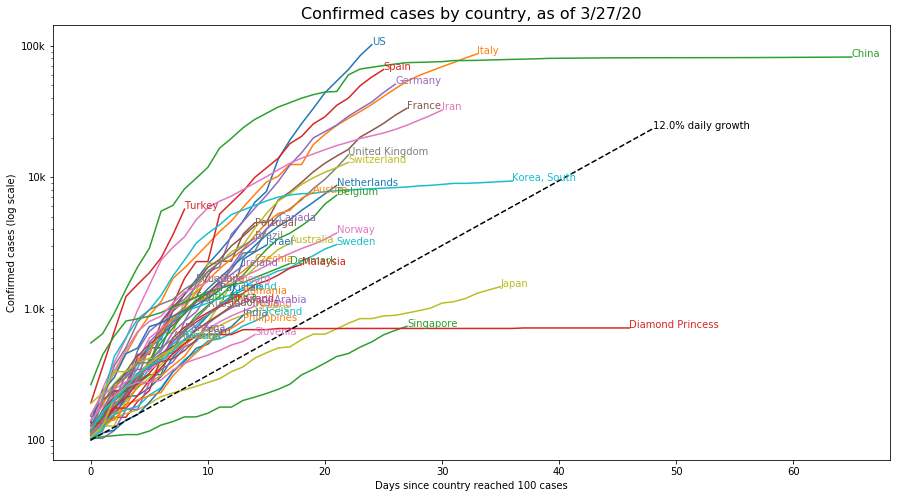

In [8]:
# Retrieve data for one country from the data frame
def getData(df, name):
    df1   =df.loc[name, df.columns[2]:]
    days  =df1.index.values
    days  =[datetime.datetime.strptime(d,"%m/%d/%y").date() for d in days]
    daynr =range(1, len(days)+1)
    values=df1.to_numpy()
    return days, daynr, values

# Crop away starting values < n from the arrays
def startAtN(values, n):
    while(len(values)>0 and values[0]<n):
        values=values[1:]
    return values

# Plot an exponential growth line with given start value and factor
def plotFactor(ax, start,factor,length):
    xs=range(0, length)
    ys=[start]
    while(len(ys)<length):
        ys.append(factor*ys[-1])

    line, =ax.plot(xs, ys,"--k")
    c=line.get_color()
    ax.text(xs[-1], ys[-1], "%.1f%% daily growth" % (factor*100-100), color=c)

# Plot time-shifted data per country, setting y=0 where the country data set crosses the threshold
def plotTimeShiftedCountries(df, refDf, validCountries, threshold, growth, yscale, label, xlabel, ylabel, yformatter):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 1, 1)

    ax.set_title(label, fontsize=16)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.yaxis.set_major_formatter(yformatter)

    # Plot individual country curves
    maxLen=0
    for i, cty in enumerate(validCountries, start=0):
        name=cty['Name']
        days, daynr, values=getData(df, name)
        if (refDf is None):
            shiftedValues=startAtN(values, threshold)
        else:
            refDays, refDaynr, refValues=getData(refDf, name)
            shiftedRefValues=startAtN(refValues, threshold)
            shiftedValues=values[-len(shiftedRefValues):] if len(shiftedRefValues)>0 else []
        if(len(shiftedValues)>0):
            if(len(shiftedValues)>maxLen):
                maxLen=len(shiftedValues)
            line, =ax.plot(range(0, len(shiftedValues)), shiftedValues)
            c=line.get_color()
            ax.text(len(shiftedValues)-1, shiftedValues[-1], name, color=c)
    
    # Plot the average growth line
    if growth!=0:
        plotFactor(ax,threshold, 1+growth, 3*maxLen//4)
   
    plt.show()

threshold=100
plotTimeShiftedCountries(confd, None, validCountries, threshold, confdGrowth, 'log', 
                         "Confirmed cases by country, as of %s" % today,
                         "Days since country reached %s cases" % humanReadable(threshold),
                         "Confirmed cases (log scale)", hrFormatter)


The picture for time-shifted deaths is similar. China and Iran have flattened. Italy is hardest hit but flattening somewhat; mirrored by France and the US. Spain is on an even steeper curve.  

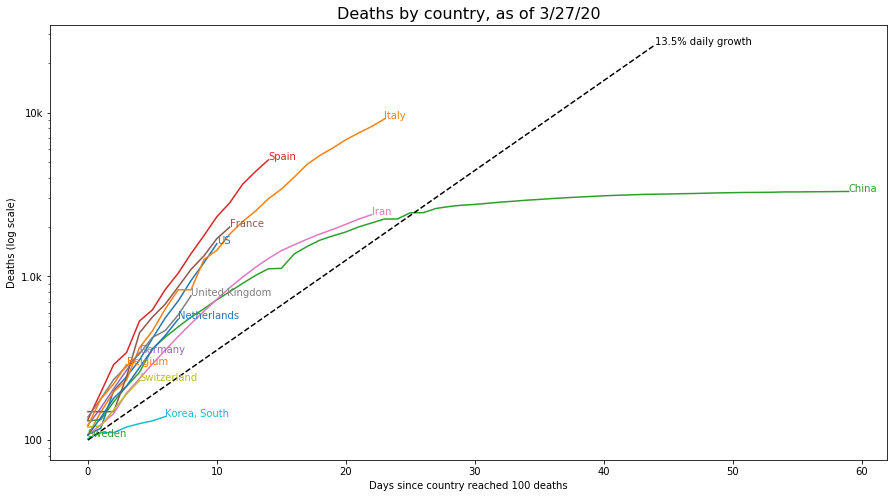

In [9]:
plotTimeShiftedCountries(deaths, None, validCountries, threshold, deathsGrowth, 'log', 
                         "Deaths by country, as of %s" % today,
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         "Deaths (log scale)", hrFormatter)

Here are the time-shifted crude CFRs, with curves shifted to the moment a country has accumulated 100 dead. Italy is by far the most impacted. Spain is following the trajectory. CFRs in Iran are trending downwards for several days now. 

So far, Germany, Switzerland, South Korea and the US appear to display markedly lower CFRs than the bulk of the western countries. However, the ratio of fatal outcomes in these countries is trending slowly upwards. 

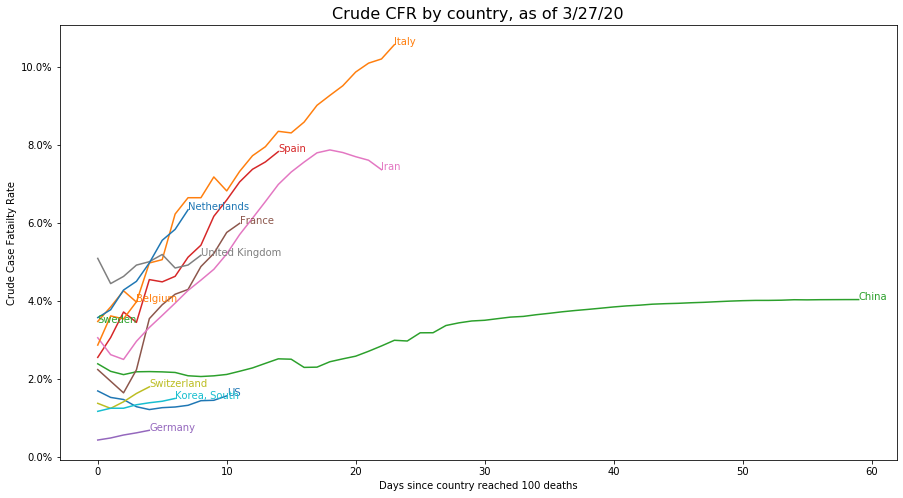

In [10]:
plotTimeShiftedCountries(deaths/confd, deaths, validCountries, threshold, 0, 'linear', 
                         "Crude CFR by country, as of %s" % today,
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         "Crude Case Fatailty Rate", plticker.PercentFormatter(1.0))

## Country Projections Overview

To project current trends, we try and fit both an exponential function, which grows without bound, and a sigmoid function, which flattens out again. We then select the curve with the lowest mean square error. Such projections should be taken with a grain of salt, as both types of functions grow and diverge rapidly. 
I have added one sigma confidence ranges to the overview to reflect the uncertainty. If errors are distributed normally, 68% of possible future outcomes should lie within these confidence bounds. Given large day-to-day swings in projections further than a week out, I am restricting predictions to a single week for now. 

If ongoing mitigations do not materially change the course of the disease, one week from now, the US would continue to bear the heaviest and expanding case load with close to 200k cases. Spain would be impacted more heavily than Italy and China, but below the US level. The UK would be impacted more heavilz than Iran, but less than France. Error bounds for Turkey are still particularly large, followed by the UK where they have widened, as well as by Belgium. Error bounds for Canada have narrowed. Fingers crossed that social distancing is going to further reduce infection rates. 

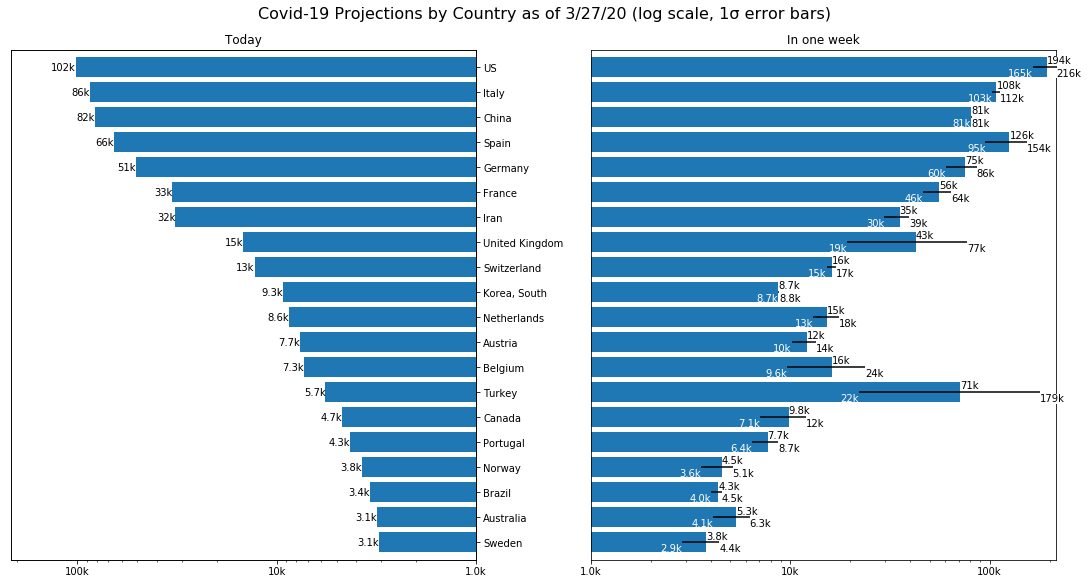

In [17]:
# Exponential model for fitting
def fitExp(t, a, b):
    return a*np.exp(b*t)

# Generate a label for the exponential model
def fitExpLabeller(popt):
    return "f(x)=%g e^(%g x)" % (s3(popt[0]), s3(popt[1]))

# Sigmoid model for fitting
def fitSig(t, a, b, c):
    return a/(1.0+np.exp(-b*t - c)) 

# Generate a label for the sigmoid model
def fitSigLabeller(popt):
    return "f(x)=%g /(1- e^(\n%+g x %+g)))" % (s3(popt[0]), s3(-popt[1]), s3(-popt[2]))

def s3(x):
    return np.around(x,decimals=3)

def extendTime(days, daynr, extraDays):
    for i in range(0, extraDays):
        days=np.append(days,days[-1]+datetime.timedelta(days=1))
        daynr=np.append(daynr, daynr[-1]+1)
    return days, daynr

# Fit given curve to the given data
def fitCurve(daynr, values, fitFunc, p0, eqFormatter):
    try:
        # fit curve
        popt, pcov=curve_fit(fitFunc, daynr, values, p0)
    
        # estimate error
        proj=fitFunc(daynr, *popt)
        sqdiff=np.sum((values-proj)**2)
        
        # generate label for chart
        equation=eqFormatter(popt) 
        if(len(proj)>=2 and proj[-2]!=0):
            growthRate=proj[-1]/proj[-2]-1
        else:
            growthRate=0
        fitLabel="%s\n%.1f%% daily growth" % (equation, 100*growthRate)
        return popt, pcov, sqdiff, fitLabel
            
    except (RuntimeError, TypeError) as e:
        return [], [], sys.float_info.max, ""


# Fit multiple functions to the curve, return the fit with the lowest square error
def fitCurves(name, daynr, values):        
    bestFitFunc, bestPopt, bestPcov, bestSqdiff, bestFitLabel=[], [], [], sys.float_info.max, ""

    if values[-1]>1:
        fittings=[
            [ fitExp, [0.1, 0.1],             fitExpLabeller ],
            [ fitSig, [values[-1], 0.1, -10], fitSigLabeller ]
        ]

        # Perform and evaluate curve fits
        fitsDiff=[]
        for fitFunc, p0, eqFormatter in fittings:
            popt, pcov, sqdiff, fitLabel=fitCurve(daynr, values, fitFunc, p0, eqFormatter)
            fitsDiff.append(sqdiff)
            if sqdiff<bestSqdiff:
                bestFitFunc, bestPopt, bestPcov, bestSqdiff, bestFitLabel=fitFunc, popt, pcov, sqdiff, fitLabel

    #print(name, humanReadable(fitsDiff[0]),  humanReadable(fitsDiff[1]), humanReadable(fitsDiff[0]/fitsDiff[1]) )
    return bestFitFunc, bestPopt, bestPcov, bestSqdiff, bestFitLabel

# Silently ignore optimize warnings when curve fitting
warnings.simplefilter("ignore", OptimizeWarning)

# Fit curve for the top K valid countries 
topK=20
extDayCount=7
confdFits, deathsFits={}, {}
confdProj7, confdProj7ErrorLow, confdProj7ErrorHigh=[], [], []
np.seterr(over='ignore')
for i, cty in enumerate(validCountries[0:topK], start=0):
    name=cty['Name']

    # Fit curve and project
    days, daynr, values=getData(confd, name)
    confdFits[name]=fitCurves(name, daynr, values)
    fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel=confdFits[name]
    extDays, extDaynr=extendTime(days, np.array(daynr), extDayCount)
    proj=fitFunc(extDaynr, *fitPopt)
    confdProj7.append(proj[len(daynr)-1+7])

    # Calculate 1 sigma error bars
    pcov1Sigma=[np.sqrt(fitPcov[i][i]) for i in range(len(fitPopt))]
    poptLower1S=fitPopt.copy()-pcov1Sigma
    extProjLower1S=fitFunc(extDaynr, *poptLower1S)
    poptUpper1S=fitPopt.copy()+pcov1Sigma
    extProjUpper1S=fitFunc(extDaynr, *poptUpper1S)    

    confdProj7ErrorLow.append(extProjLower1S[-1])    
    confdProj7ErrorHigh.append(extProjUpper1S[-1])    
        
    days, daynr, values=getData(deaths, name)
    deathsFits[name]=fitCurves(name, daynr, values)
    
# Plot overview of projections
plt.rcParams['figure.figsize'] = [15, 8]
fig, ax=plt.subplots(nrows=1, ncols=2, constrained_layout=True)
fig.suptitle('Covid-19 Projections by Country as of %s (log scale, 1\u03C3 error bars)' % today, fontsize="16")

# Leftmost chart: Plot lastest confirmed cases by country
ax[0].set_title('Today')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames[:topK], countryCases[:topK])
for i, v in enumerate(countryCases[:topK]):
    ax2.text(v, i, humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

low=1000
high=max(max(proj), max(confdProj7ErrorLow), max(confdProj7ErrorHigh))

# Subsequent charts: plot projections for some weeks out
for i, title, proj in [(1, "In one week", confdProj7)]: 
    ax[i].set_title(title)
    ax[i].set_xscale('log')
    ax[i].xaxis.set_major_formatter(hrFormatter)
    ax[i].invert_yaxis()
    ax[i].get_yaxis().set_visible(False)
    ax[i].margins(0.015)
    ax[i].barh(countryNames[:topK], proj, xerr=(np.array(proj)-np.array(confdProj7ErrorLow),
                                                np.array(confdProj7ErrorHigh)-np.array(proj)) )
    
    for j, v in enumerate(confdProj7ErrorLow):
        if v>low:
            ax[i].text(v, j+0.25, humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'), color='w')
    for j, v in enumerate(confdProj7ErrorHigh):
        if v>low:
            ax[i].text(v, j+0.25, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

    # then label midpoint value
    for j, v in enumerate(proj):
        ax[i].text(v, j-0.25, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
            
# Ensure all charts are drawn to the same scale
ax2.set_xlim(high,low)
_,_=ax[1].set_xlim(low, high)
        

# Country Projection Details

Three charts per country: confirmed cases, recovered cases and deaths. Black dots show the actual values from Hopkins. The smooth lines have been fitted to the data, using the same curve fits as above. The dashed lines are one standard deviation error bounds to the fitted data. If errors are distributed normally, 68% of possible future outcomes should fall within these bounds. The dotted lines are error bounds of two standard deviations, which should encompass 95% of outcomes.

Projected results are grim. One week from now, the US, Italy and Spain could end up in the neigborhood of 10k fatal outcomes each. 

For the mathematically inclined, I'm using the square root of the diagonal of the covariance matrix to estimate standard deviations for each parameter individually; I am cavalierly neglecting the other parts of the covariance matrix which capture interdepdencies between the parameters. There clearly are limits to this two sigma approach: e.g., for some countries, the two sigma lower bound of the one week projection ends up lower than the already confirmed number of cases, which is counterintuitive for a monotonically growing function. Still, the one sigma bounds visually appear reasonable. 

The curve for Korea continues to depart from both exponential and sigmoid growth functions. Please disregard for now; happy to have your suggestions for a better family of functions to fit. 

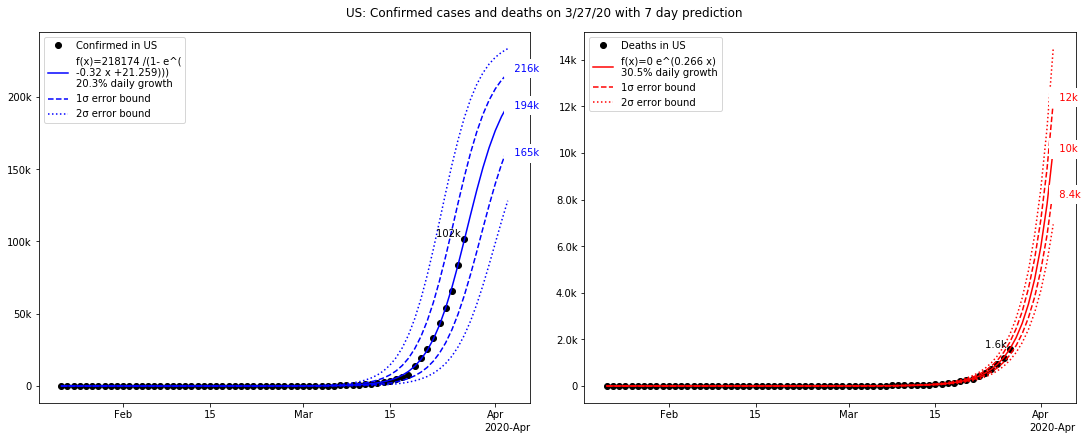

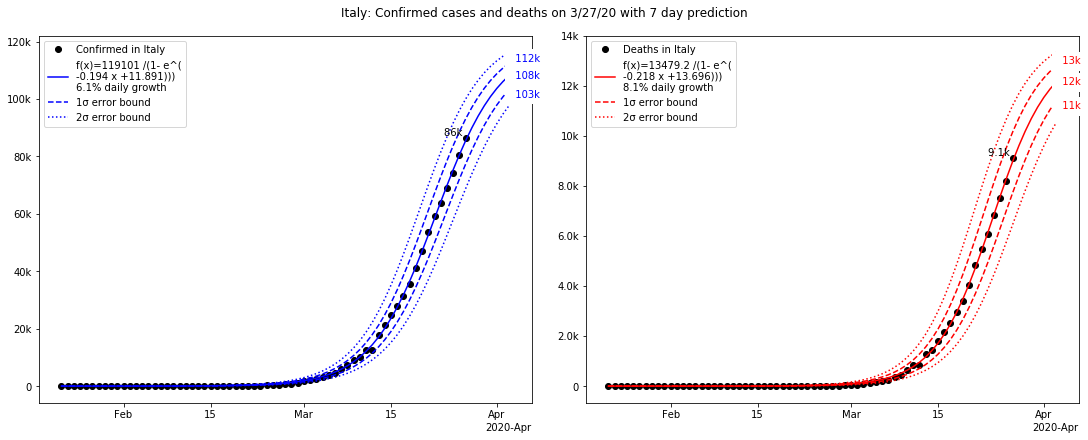

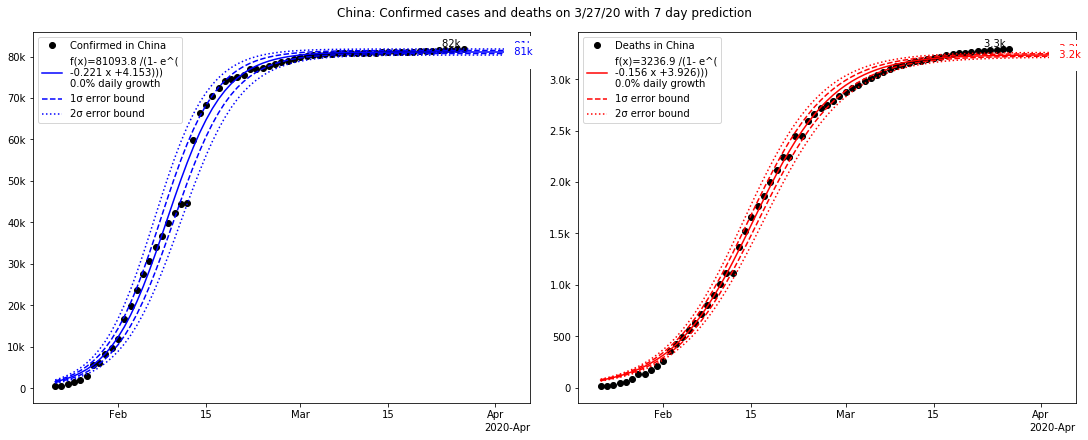

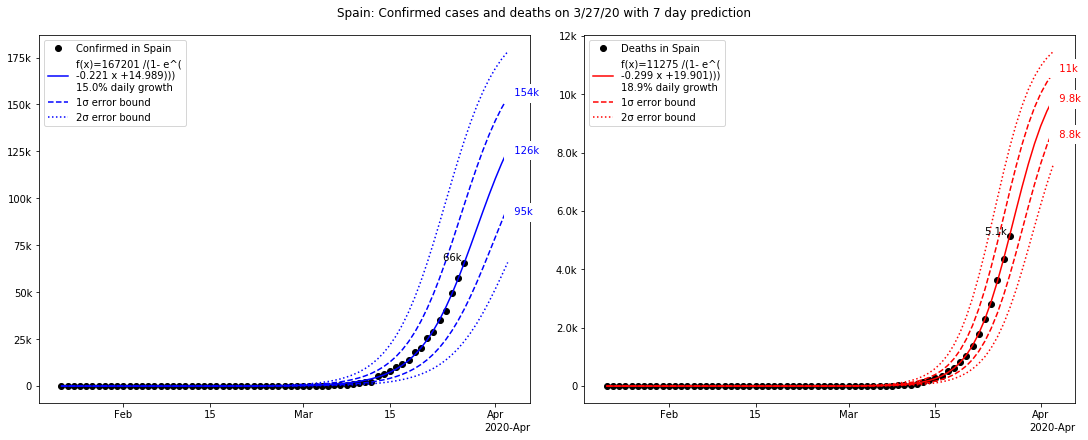

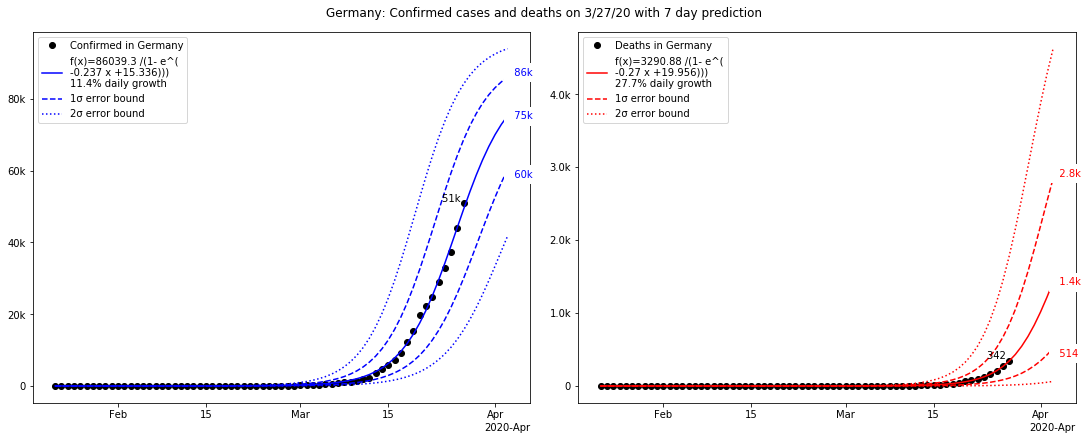

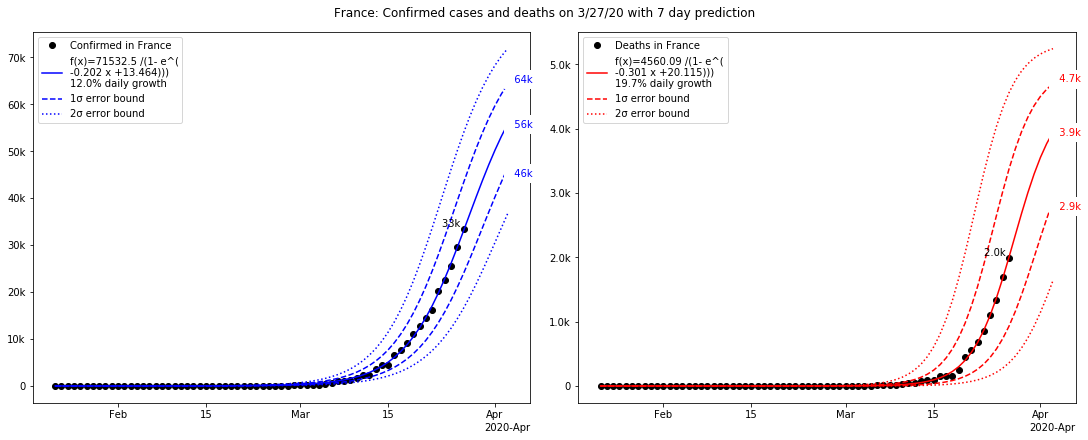

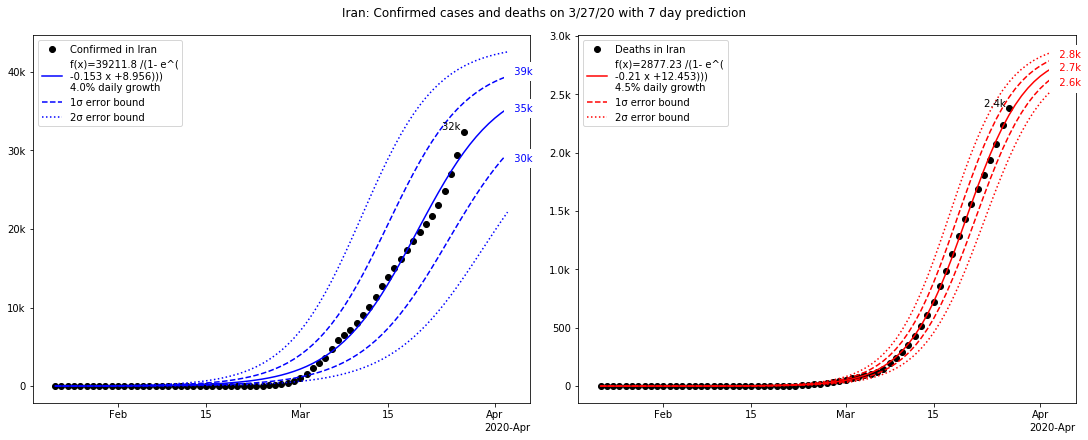

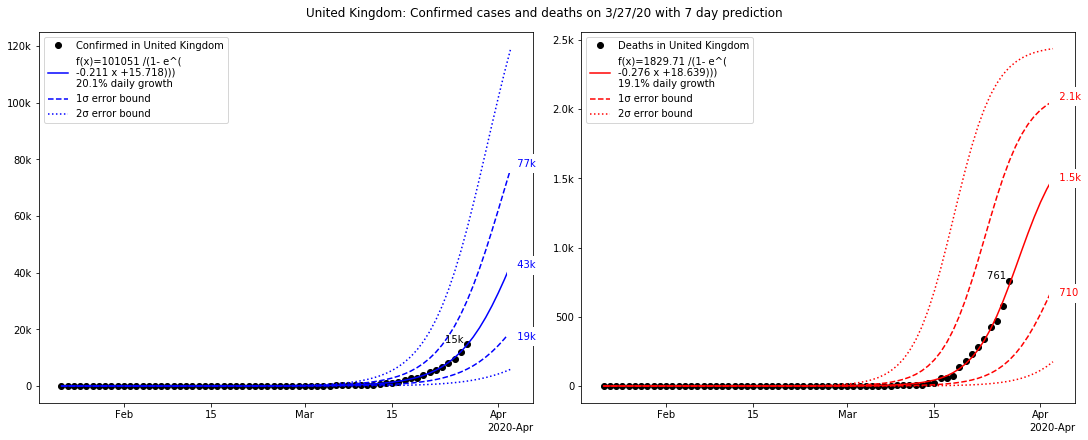

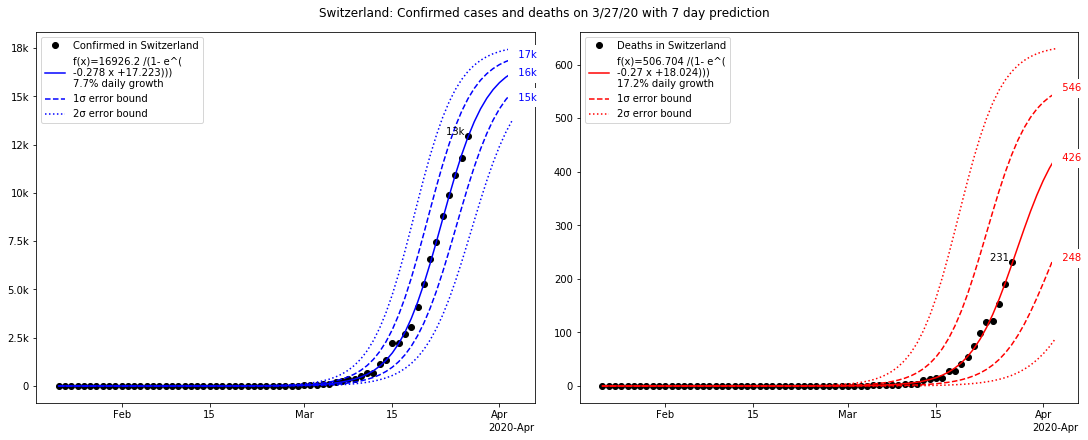

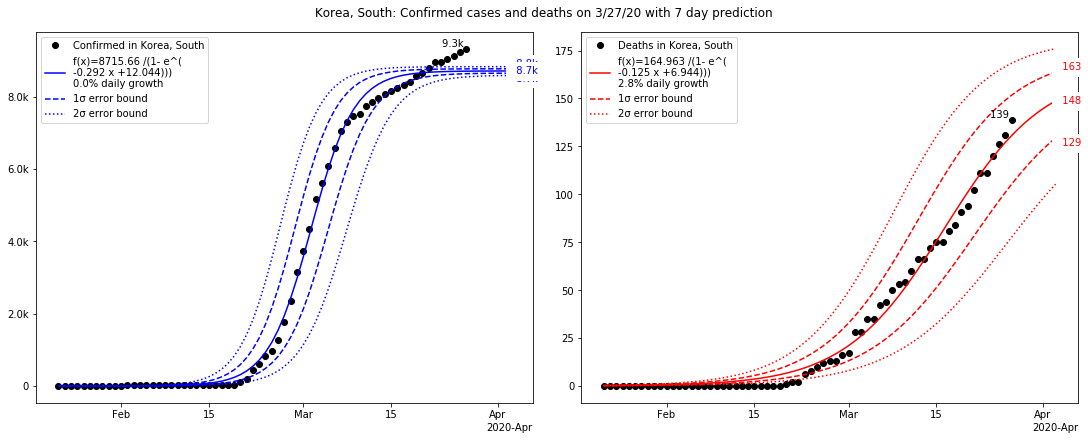

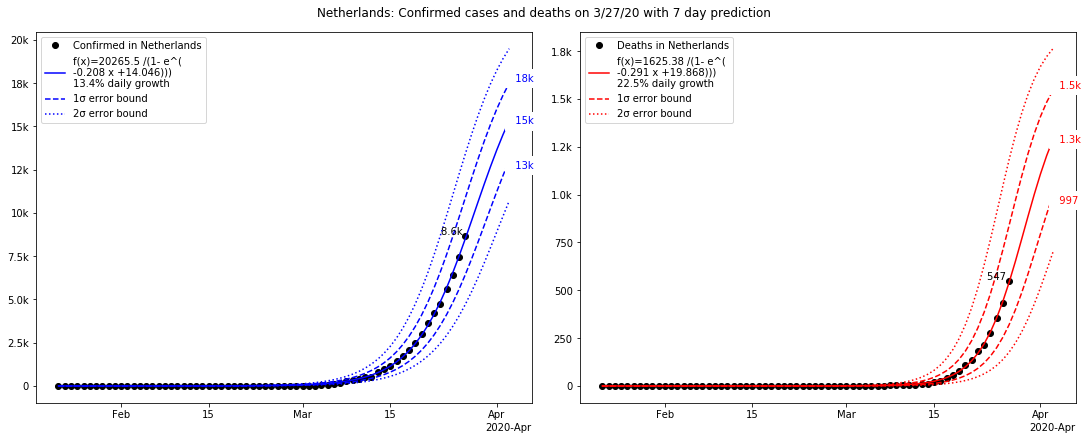

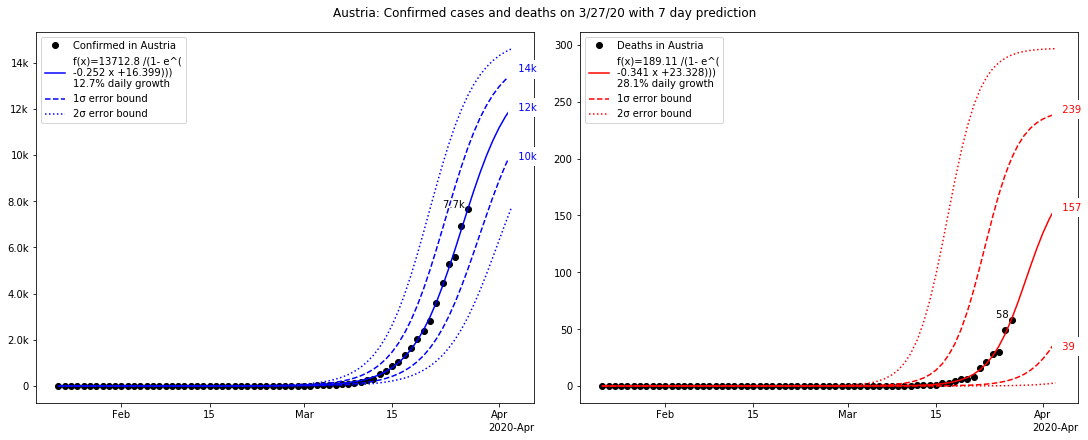

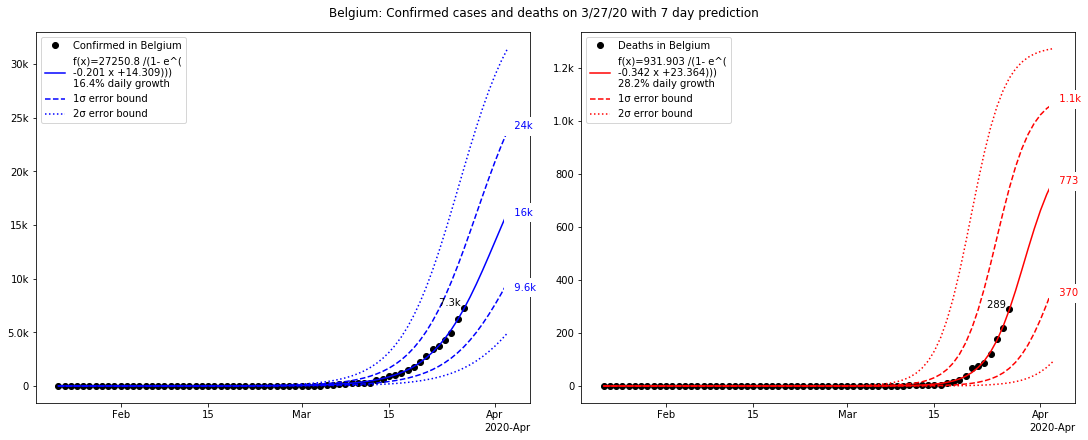

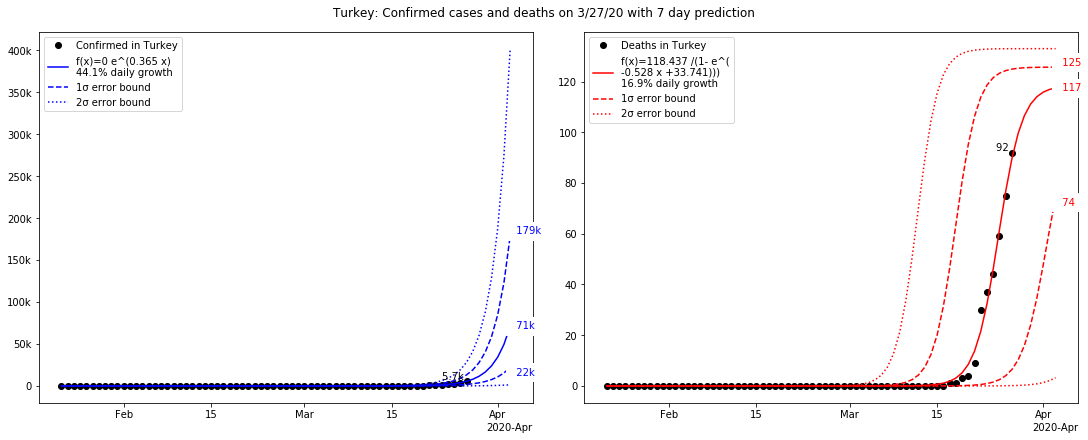

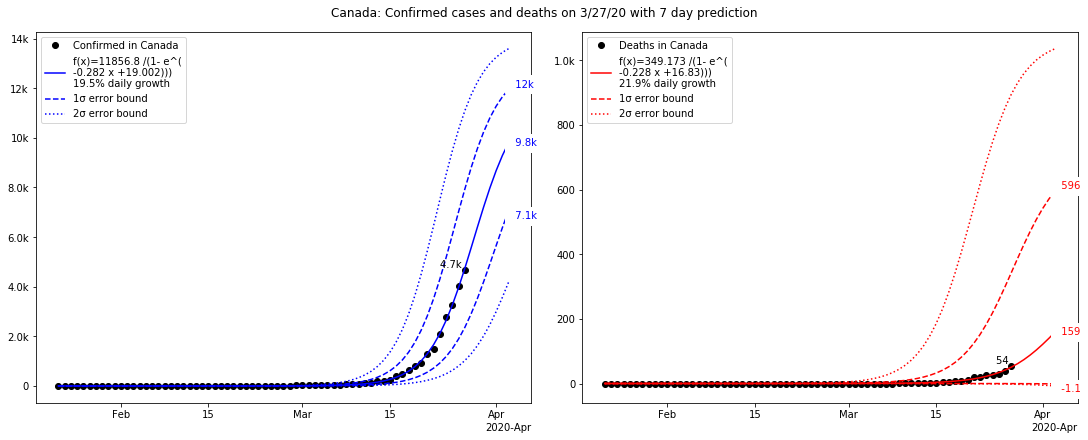

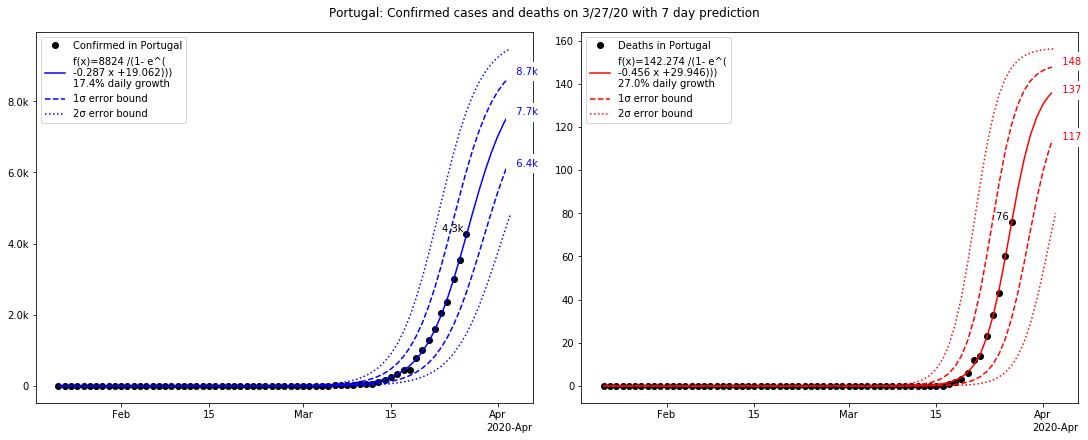

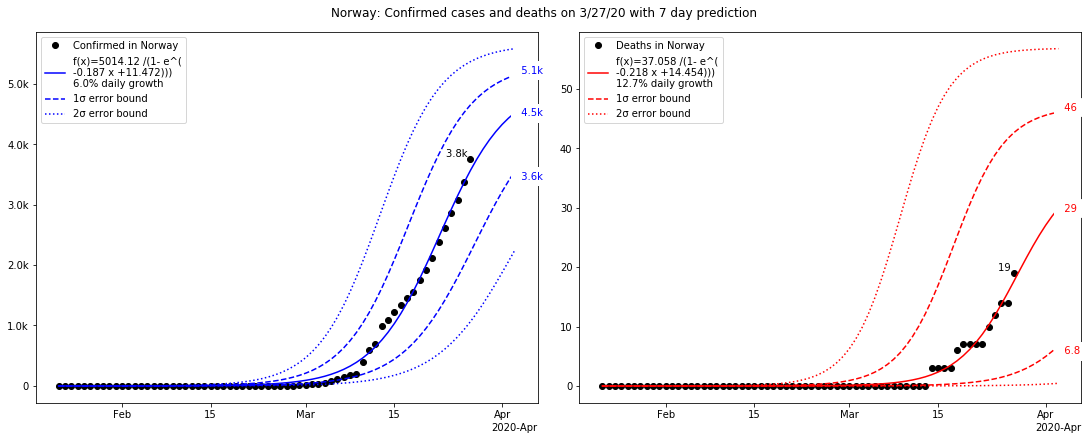

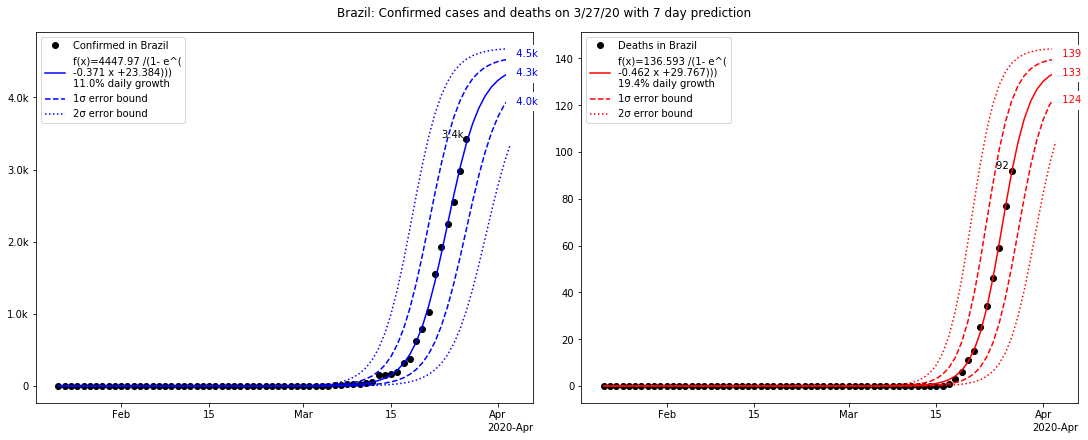

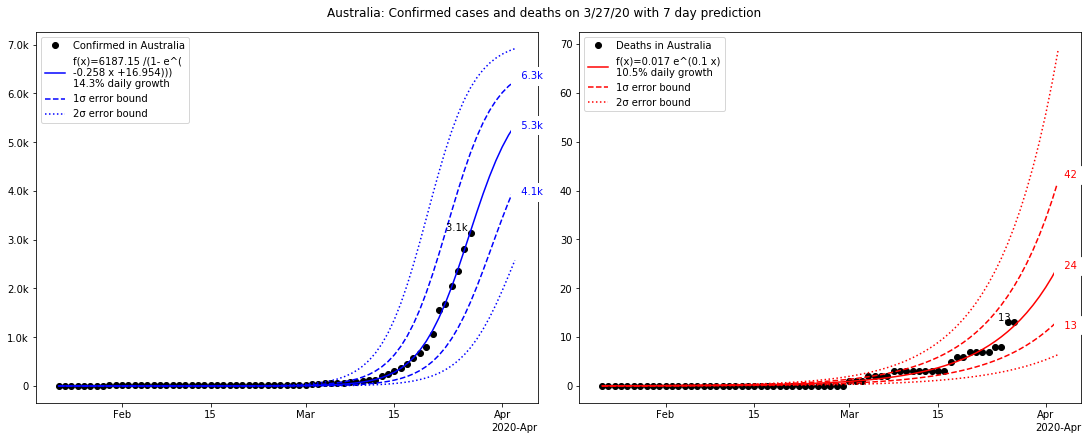

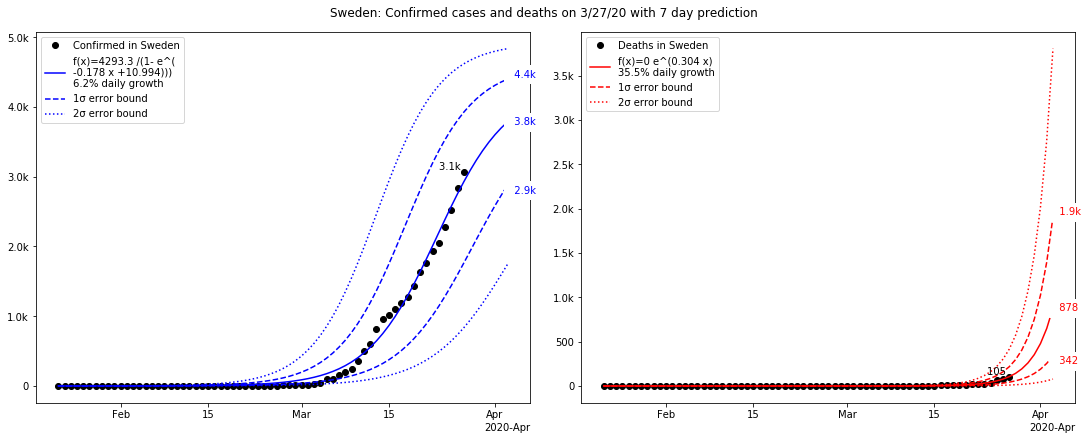

In [12]:
# Plot the raw data and the fitted curve on the given axes
def plotRawAndCurve(days, daynr, values, fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel, ax, label, name, fitDrawingStyle, extDayCount, yScale='linear'):
    # Plot raw data and label last data point 
    ax.set_yscale(yScale)
    ax.plot(days, values, 'ko', label="%s in %s" % (label, name))
    ax.text(days[-1], values[-1], "%s " % humanReadable(values[-1]), color='k', horizontalalignment="right", verticalalignment="bottom")

    # Plot the best fit projection, if it exists
    if fitSqdiff<sys.float_info.max:
        extDays, extDaynr=extendTime(days, np.array(daynr), extDayCount)

        # Calculate error bounds.
        # For simplicity, we are taking the diagonal of the covariance matrix,
        # i.e. the variances of each parameter with itself. The square root
        # of that is one standard deviation. 
        pcov2Sigma=[2*np.sqrt(fitPcov[i][i]) for i in range(len(fitPopt))]
        pcov1Sigma=[  np.sqrt(fitPcov[i][i]) for i in range(len(fitPopt))]

        # Plot 2 sigma lower error bound 
        poptLower2S=fitPopt.copy()-pcov2Sigma
        extProjLower2S=fitFunc(extDaynr, *poptLower2S)
        line, =ax.plot(extDays, extProjLower2S,  "%s:" % fitDrawingStyle[:-1])

        # Plot 1 sigma lower error bound
        poptLower1S=fitPopt.copy()-pcov1Sigma
        extProjLower1S=fitFunc(extDaynr, *poptLower1S)
        line, =ax.plot(extDays, extProjLower1S,  "%s-" % fitDrawingStyle)
        ax.text(extDays[-1], extProjLower1S[-1], "  %s" % humanReadable(extProjLower1S[-1]), color=line.get_color(), backgroundcolor='w', ha="left", va="top" )

        # Plot projected scenario 
        extProj=fitFunc(extDaynr, *fitPopt)
        line, =ax.plot(extDays, extProj,  fitDrawingStyle, label=fitLabel)

        # Plot 1 sigma upper error bound
        poptUpper1S=fitPopt.copy()+pcov1Sigma
        extProjUpper1S=fitFunc(extDaynr, *poptUpper1S)
        line, =ax.plot(extDays, extProjUpper1S,  "%s-" % fitDrawingStyle, label="1\u03C3 error bound")
        ax.text(extDays[-1], extProjUpper1S[-1], "  %s" % humanReadable(extProjUpper1S[-1]), color=line.get_color(), backgroundcolor='w', ha="left", va="bottom" )

        # Plot 2 sigma upper error bound
        poptUpper2S=fitPopt.copy()+pcov2Sigma
        extProjUpper2S=fitFunc(extDaynr, *poptUpper2S)
        line, =ax.plot(extDays, extProjUpper2S,  "%s:" % fitDrawingStyle[:-1], label="2\u03C3 error bound")

        #poptHigh=fitPopt.copy()+pcov2Sigma
        #extProjHighP=fitFunc(extDaynr, *poptHigh)
        #line, =ax.plot(extDays, extProjHighP,  "%s:" % fitDrawingStyle[:-1], label=None)

        # Label projected scenario last, so it appears on top
        ax.text(extDays[-1], extProj[-1], "  %s" % humanReadable(extProj[-1]), color=line.get_color(), backgroundcolor='w', ha="left", va="center" )

    # Finish up the formatting
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(hrFormatter)
    ax.legend()
    
# Plot fits for the top K valid countries and given number of extension days
extDayCount=7
for i, cty in enumerate(validCountries[0:topK], start=0):
    # Retrieve data and fit
    name=cty['Name']
    
    # Prepare plot area
    plt.rcParams['figure.figsize'] = [15, 6]
    fig, axs=plt.subplots(nrows=1, ncols=2, constrained_layout=True)
    plt.suptitle('%s: Confirmed cases and deaths on %s with %d day prediction' % (name, today, extDayCount))

    # Select and plot data for this country
    chartParams=[(confd, confdFits, axs[0], "Confirmed", "b-"), (deaths, deathsFits, axs[1], "Deaths", "r-")]
    #chartParams=[(confd, confdFits, axs[0], "Confirmed", "b-"), (recovd, recovdFits, axs[1], "Recovered", "g-"), (deaths, deathsFits, axs[2], "Deaths", "r-")]
    for df, fits, ax, legend, fitDrawingStyle in chartParams:
        days, daynr, values=getData(df, name)
        fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel=fits[name]
        plotRawAndCurve(days, daynr, values, fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel, ax, legend, name, fitDrawingStyle, extDayCount, yScale='linear')
    plt.show()

Return to [daily series overview](https://mlnoga.github.io/covid19-analysis/).

For questions and comments, please reach out to me on [LinkedIn](https://www.linkedin.com/in/mlnoga/) or [Twitter](https://twitter.com/mlnoga).